# Cyclones: Exploratory Analysis

In [2]:
# %matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime 
import seaborn as sns
from matplotlib import pyplot as plt

from utils.jtwc_cyclone_utils import get_southern_hem_data, get_NWP_data
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [3]:
south_df = get_southern_hem_data(one_per_id=True)
nwp_df = get_NWP_data(one_per_id=True)
cyclone_df = pd.concat([south_df, nwp_df], ignore_index=True).sort_values(by=['Storm ID', 'timestamp'])
cyclone_df



,timestamp,Storm ID,BASIN,Season,SEASON TC NUMBER,Latitude (degrees),Longitude (degrees),VMAX (kt),Peak VMAX (kt),ACE,Maximum 24h Intensification
911,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,7.1,153.0,15.0,60.0,0.73250,15.0
919,1982-07-21 12:00:00,1982-N-10,WP,1982.0,10.0,11.1,147.0,25.0,120.0,2.31350,25.0
920,1982-07-22 00:00:00,1982-N-11,WP,1982.0,11.0,11.1,163.8,25.0,140.0,3.55175,35.0
921,1982-08-04 12:00:00,1982-N-12,WP,1982.0,12.0,19.8,130.9,20.0,125.0,2.14875,45.0
922,1982-08-08 00:00:00,1982-N-13,WP,1982.0,13.0,7.7,153.9,20.0,80.0,0.86525,25.0
...,...,...,...,...,...,...,...,...,...,...,...
1880,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,20.2,166.3,20.0,40.0,0.10600,10.0
1881,2022-12-08 00:00:00,2022-N-29,WP,2022.0,29.0,6.4,133.1,15.0,50.0,0.17550,20.0
1863,2022-04-08 12:00:00,2022-N-3,WP,2022.0,3.0,10.5,127.5,15.0,40.0,0.13000,15.0
1864,2022-06-29 00:00:00,2022-N-4,WP,2022.0,4.0,14.9,116.5,20.0,75.0,0.42450,20.0


In [19]:
## peak wind summary stats
print(cyclone_df['Peak VMAX (kt)'].mean())
print(cyclone_df['Peak VMAX (kt)'].std())
print(cyclone_df['Peak VMAX (kt)'].quantile(0.25))
print(cyclone_df['Peak VMAX (kt)'].quantile(0.5))
print(cyclone_df['Peak VMAX (kt)'].quantile(0.75))


82.79702444208289
33.41674144643461
55.0
75.0
110.0


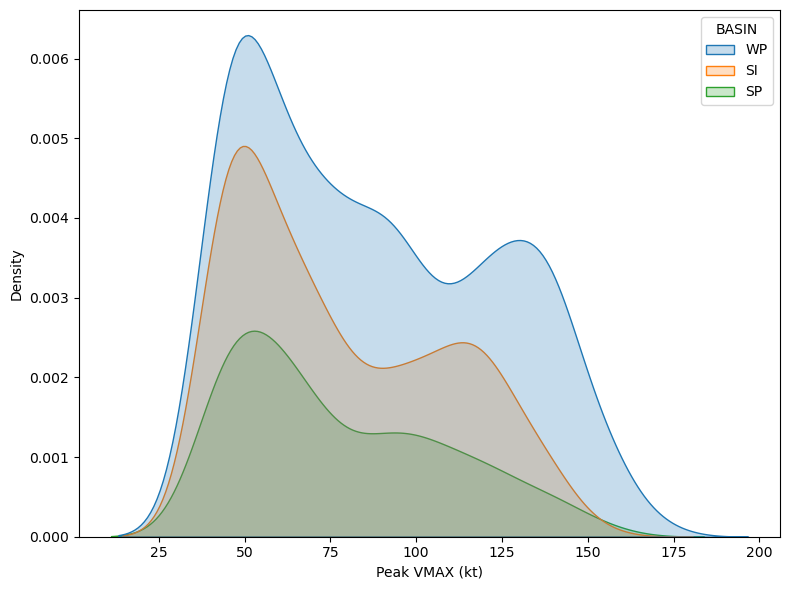

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=cyclone_df, x='Peak VMAX (kt)', hue='BASIN', common_norm=True, fill=True,  multiple='layer', ax=ax)
plt.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/wind_kde_basin.png')

number of real cyclones with season between 1982.0 and 1991.0: 489
number of real cyclones with season between 1991.0 and 2000.0: 513
number of real cyclones with season between 2000.0 and 2012.0: 542
number of real cyclones with season between 2012.0 and 2022.0: 473


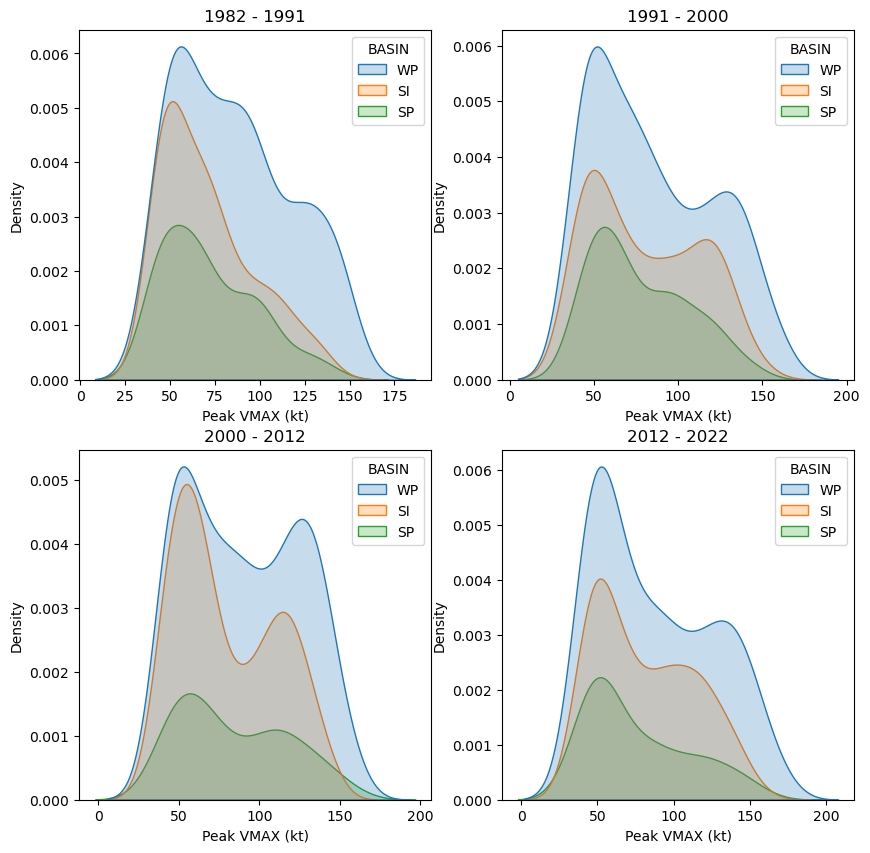

In [25]:
## examine changes in distribution over the decades??
fig, axs = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
row = 0
col = 0
# split into 4 quantiles
for (lower_p, upper_p) in [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]: 
    lower_q = cyclone_df['Season'].quantile(lower_p)
    upper_q = cyclone_df['Season'].quantile(upper_p)

    # sim_lower_q = wind_predictions_df[variable].quantile(lower_p)
    # sim_upper_q = wind_predictions_df[variable].quantile(upper_p)

    slice = cyclone_df.loc[(cyclone_df.loc[:, 'Season'] >= lower_q) & (cyclone_df.loc[:, 'Season'] <= upper_q)]

    print(f'number of real cyclones with season between {lower_q} and {upper_q}: {slice.shape[0]}')

    ax = sns.kdeplot(data=slice, x='Peak VMAX (kt)', hue='BASIN', common_norm=True, fill=True,  multiple='layer',ax=axs[row][col])
    ax.set_title(f'{int(lower_q)} - {int(upper_q)}')

    col += 1
    if col == 2:
        col = 0;
        row += 1

plt.show()

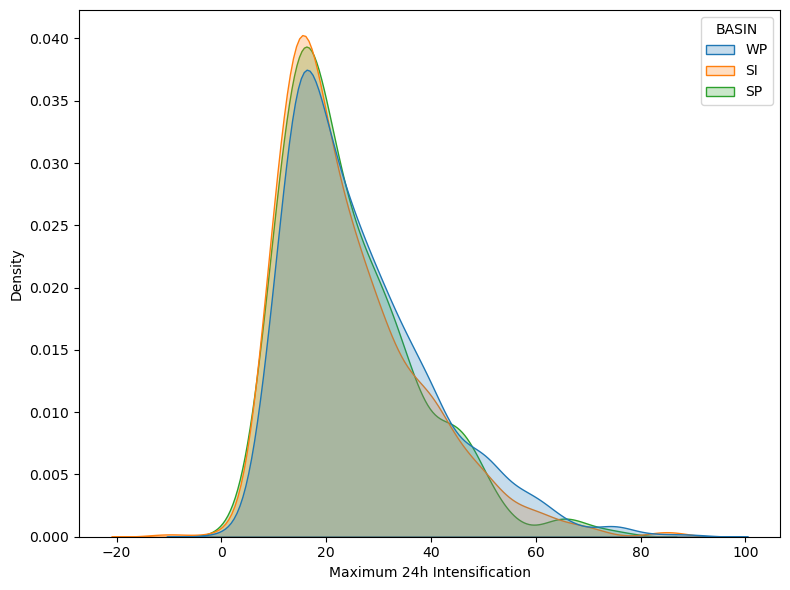

In [6]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=cyclone_df, x='Maximum 24h Intensification', hue='BASIN', common_norm=False, multiple='layer', fill=True, ax=ax)
plt.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/max_intensification.png')

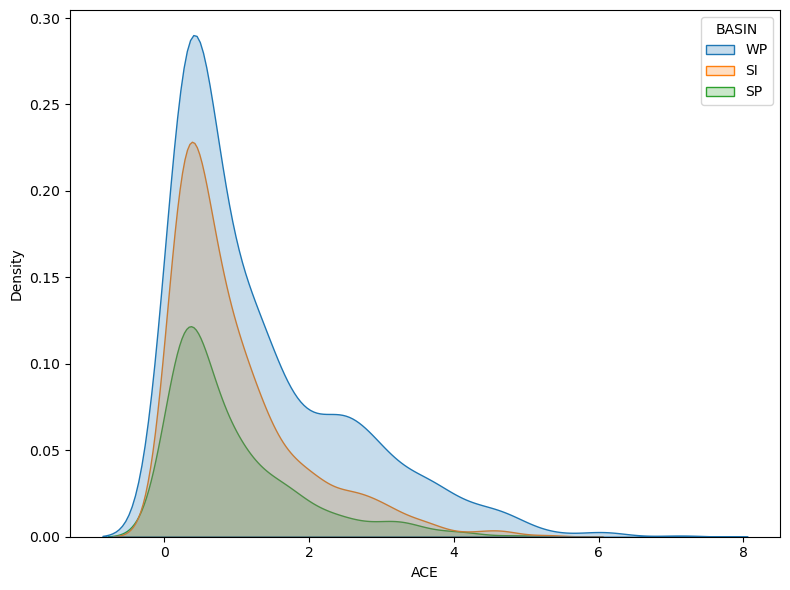

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=cyclone_df, x='ACE', hue='BASIN', common_norm=True, fill=True, multiple='layer', ax=ax)
plt.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/ace_kde.png')

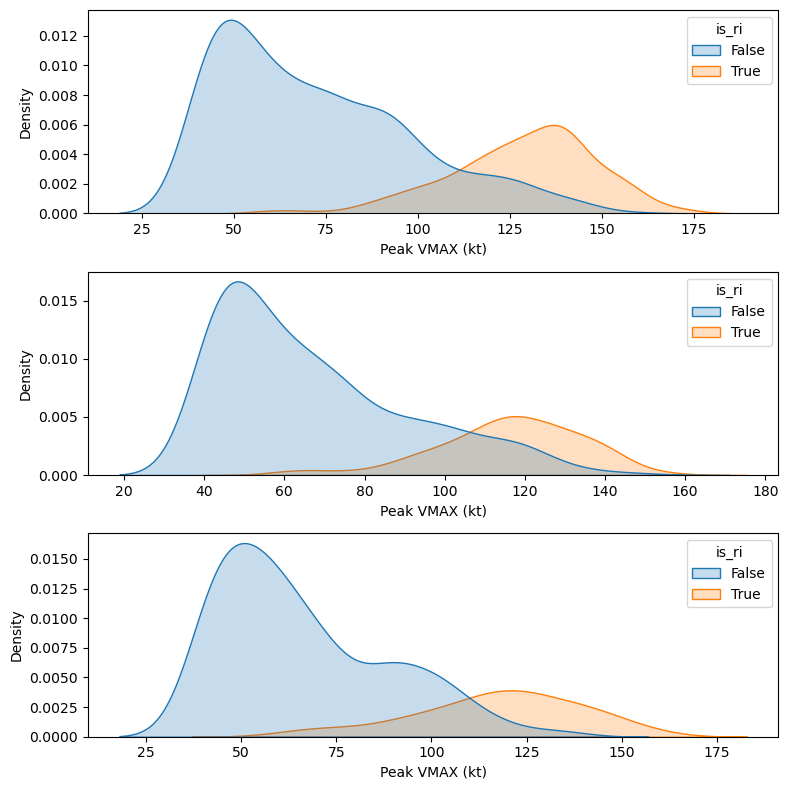

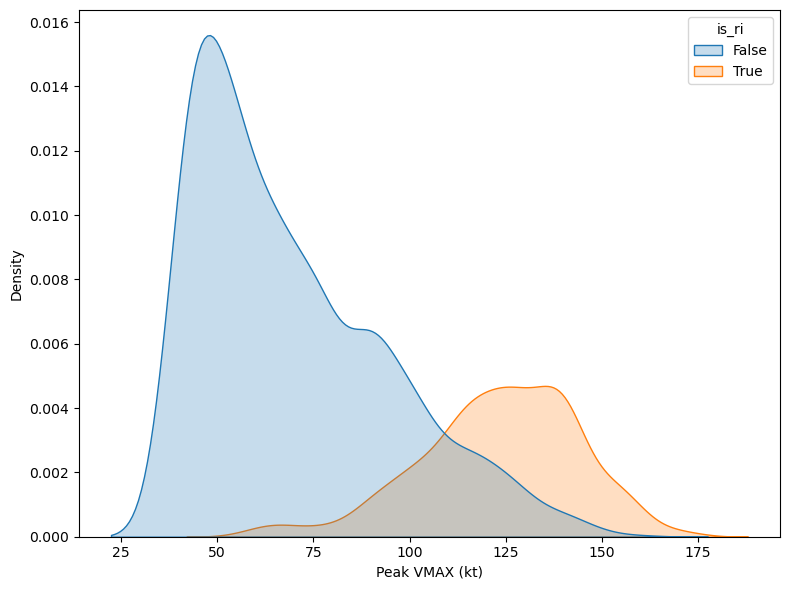

In [26]:
cyclone_df['is_ri'] = cyclone_df['Maximum 24h Intensification'].apply(lambda x: True if x >= 35 else False)

dfs = {}
for basin_name in cyclone_df['BASIN'].unique():
    dfs[basin_name] = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == basin_name]

# wp_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'WP']
# si_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'SI']
# aus_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'AUS']
# sp_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'SP']

fig, axs = plt.subplots(figsize=(8,8), nrows=3, ncols=1)

# df_mappings = [
#     [{'name': 'South Indian', 'df': si_df},{'name': 'South Pacific', 'df': sp_df}],
#     [{'name': 'Australia', 'df': aus_df},{'name': 'Northwest Pacific', 'df': wp_df}]
# ]

i = 0
for basin_name in dfs.keys():
    # for col in range(len(df_mappings[row])):
    sns.kdeplot(data=dfs[basin_name], x='Peak VMAX (kt)', hue='is_ri', common_norm=True, fill=True, multiple='layer', ax=axs[i])
    i += 1

plt.tight_layout()
plt.show() #TODO: do it by basin
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/wind_kde_ri.png')


fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=cyclone_df, x='Peak VMAX (kt)', hue='is_ri', common_norm=True, fill=True, ax=ax)
plt.tight_layout()
plt.show() #TODO: do it by basin


## Cyclone Formation Sites

In [9]:
## only show origin sites for now
min_long = cyclone_df['Longitude (degrees)'].min()
min_lat = cyclone_df['Latitude (degrees)'].min()

max_long = cyclone_df['Longitude (degrees)'].max()
max_lat = cyclone_df['Latitude (degrees)'].max()
centre_long = (max_long-min_long)/2

print('latitude: ' + str(min_lat) + ' to ' + str(max_lat))
print('longitude: ' + str(min_long) + ' to ' + str(max_long))

latitude: -30.0 to 31.3
longitude: 32.3 to 228.6


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


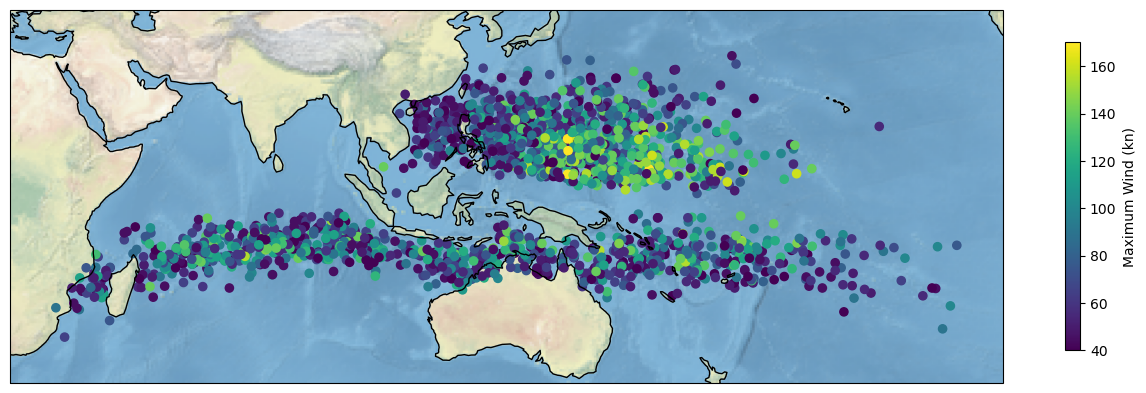

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [10]:
height = 5
fig = plt.figure(figsize=((max_long - min_long)/(max_lat-min_lat)*height, height))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= centre_long))
ax.set_extent([min_long - 10, max_long + 10 ,min_lat - 10,max_lat + 10], ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=cyclone_df['Longitude (degrees)'], y=cyclone_df['Latitude (degrees)'], cmap='viridis',c=cyclone_df['Peak VMAX (kt)'], transform=ccrs.PlateCarree(), s=35)
cbar = fig.colorbar(scatter,shrink=0.8)

cbar.set_label('Maximum Wind (kn)')

plt.show()
fig.tight_layout()
fig.savefig('./media/Cyclone/new_basins/cyclone_map/all_cyclones.png')

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


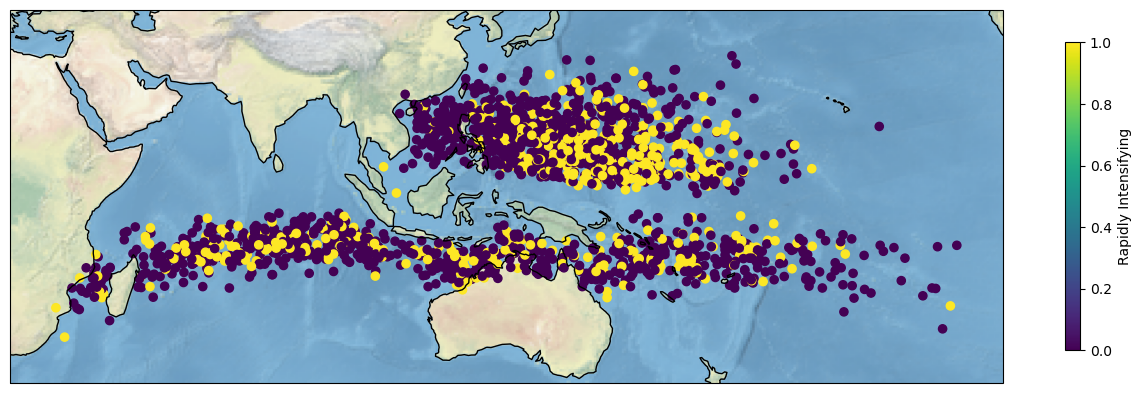

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [20]:
height = 5
fig = plt.figure(figsize=((max_long - min_long)/(max_lat-min_lat)*height, height))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= centre_long))
ax.set_extent([min_long - 10, max_long + 10 ,min_lat - 10,max_lat + 10], ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=cyclone_df['Longitude (degrees)'], y=cyclone_df['Latitude (degrees)'], cmap='viridis',c=cyclone_df['is_ri'], transform=ccrs.PlateCarree(), s=35)
cbar = fig.colorbar(scatter,shrink=0.8)

cbar.set_label('Rapidly Intensifying')

plt.show()
fig.tight_layout()
fig.savefig('./media/Cyclone/new_basins/cyclone_map/all_cyclones_ri.png')

### When do cyclones mainly occur???


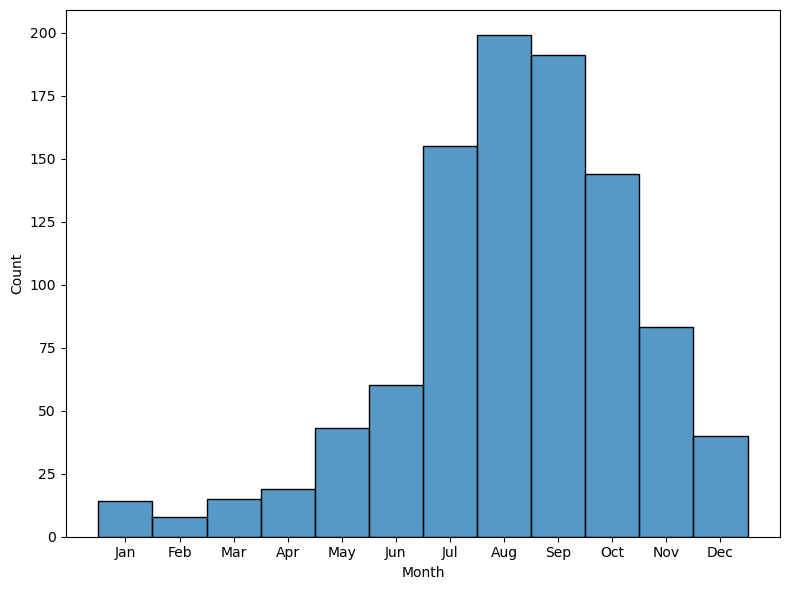

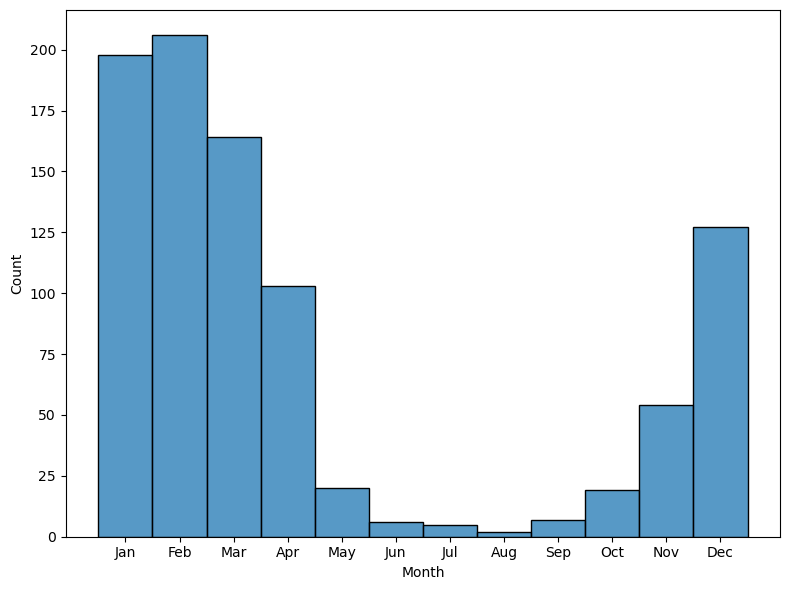

In [11]:
from utils.cyclone_utils import get_datetime, get_category
with_month = cyclone_df




## Group into categories
# with_month['Saffir Simpson Category'] = with_month['Peak VMAX (kt)'].apply(get_category)

with_month['numeric_month'] = with_month['timestamp'].apply(lambda t: get_datetime(t).month)
with_month = with_month.sort_values(by=['numeric_month'])
with_month['Month'] = with_month['timestamp'].apply(lambda t: get_datetime(t).strftime('%b'))

fig, ax = plt.subplots(figsize=(8, 6))
# NORTHERN HEMISPHERE
sns.histplot(with_month.loc[with_month.loc[:, 'BASIN'] == 'WP'], x='Month',binwidth=3)
plt.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/nwp_yearly_distribution.png')

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(with_month.loc[with_month.loc[:, 'BASIN'] != 'WP'], x='Month',binwidth=3)
plt.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/sh_yearly_distribution.png')
# SOUTHERN HEMISPHERE



# Temporal Trends

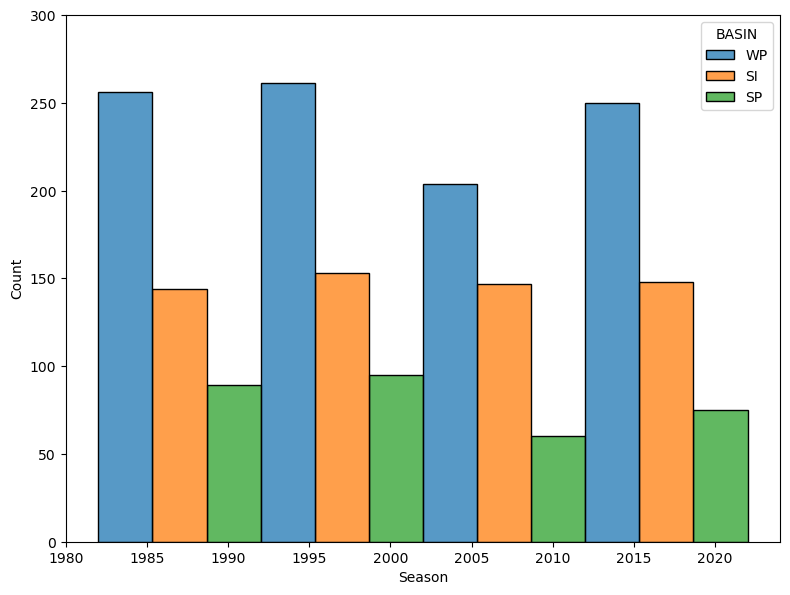

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(cyclone_df, x='Season',hue='BASIN', hue_order=['WP', 'SI', 'SP'], multiple='dodge', binwidth=10)
fig.tight_layout()
ax.set_ybound(0,300)
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/count_trend.png')
plt.show()



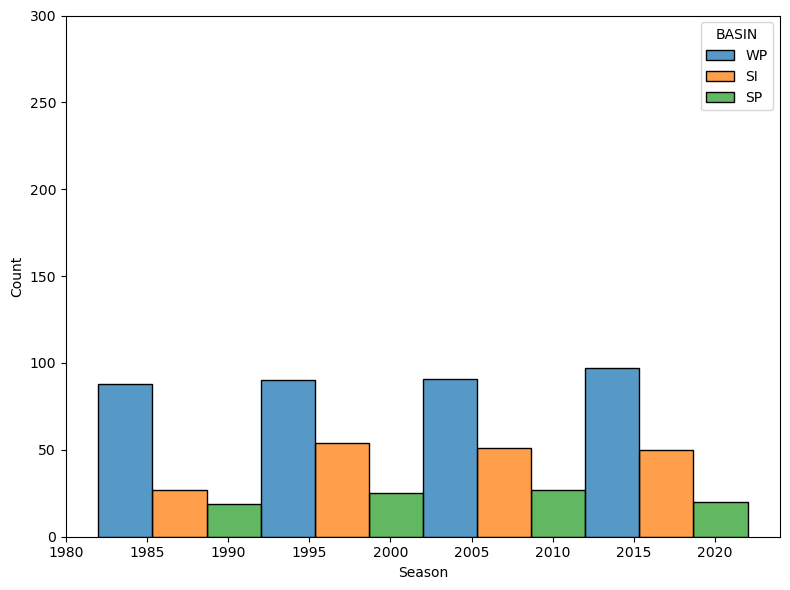

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
severe_df = cyclone_df.loc[cyclone_df.loc[:,'Peak VMAX (kt)'] > 95]
hist = sns.histplot(severe_df, x='Season',hue='BASIN', multiple='dodge', hue_order=['WP', 'SI', 'SP'], binwidth=10, ax=ax)
ax.set_ybound(0,300)
fig.tight_layout()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/severe_count_trend.png')

# Trends in extreme values

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_6872/3639518700.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_90quantile = df.groupby(by='Season').quantile(0.75)
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_6872/3639518700.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['over_quantile'] = df.apply(lambda row: row['Peak VMAX (kt)'] > df_90quantile.iloc[int(row['Season']) - FIRST_SEASON]['Peak VMAX (kt)'], axis=1)
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_6872/3639518700.py:21: FutureWarning: The

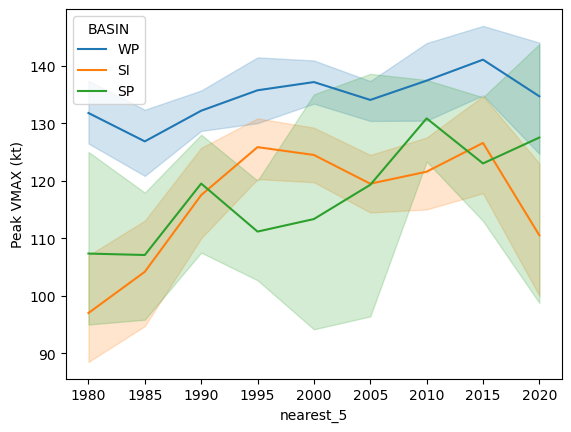

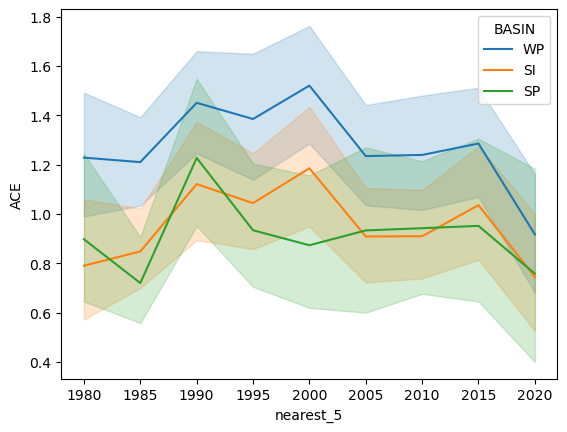

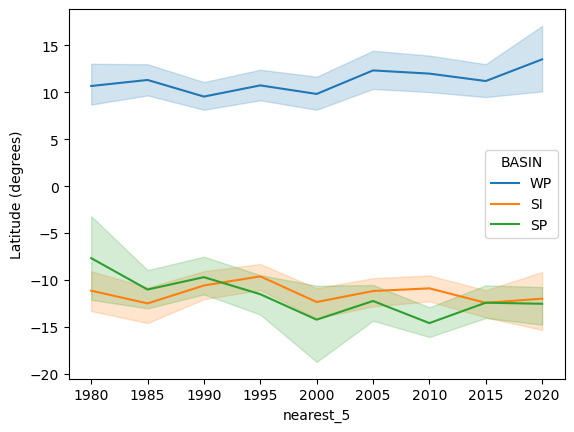

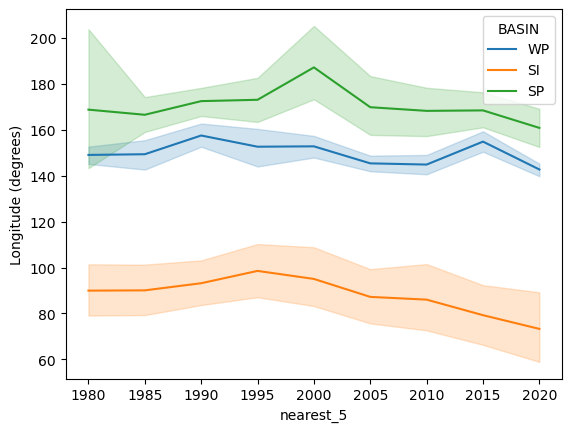

In [14]:
## strongest 10% of storms per basin per season
FIRST_SEASON = 1982

extreme_df = None

# 5 year intervals
cyclone_df['nearest_5'] = cyclone_df['Season'].apply(lambda x: int(x/5) * 5)

dfs = {}
for basin_name in cyclone_df['BASIN'].unique():
    dfs[basin_name] = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == basin_name]


for basin_name in dfs.keys():
# si_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'SI']
# sp_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'SP']
# wp_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'WP']
# aus_df = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == 'AUS']
# for df in [si_df, sp_df, wp_df, aus_df]: 
    df = dfs[basin_name]
    df_90quantile = df.groupby(by='Season').quantile(0.75)
    df['over_quantile'] = df.apply(lambda row: row['Peak VMAX (kt)'] > df_90quantile.iloc[int(row['Season']) - FIRST_SEASON]['Peak VMAX (kt)'], axis=1)
    df = df.loc[df.loc[:, 'over_quantile']]
    if extreme_df is None:
        extreme_df = df
    else:
        extreme_df = pd.concat([extreme_df, df])

extreme_df


fig, ax = plt.subplots()
sns.lineplot(extreme_df, x='nearest_5', y='Peak VMAX (kt)', hue='BASIN', hue_order=['WP', 'SI', 'SP'], ax=ax)
plt.show()
fig.tight_layout()
ax.set_xlabel("Year")
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/extreme_cyclones_trend.png')

fig, ax = plt.subplots()
sns.lineplot(cyclone_df, x='nearest_5', y='ACE', hue='BASIN', hue_order=['WP', 'SI', 'SP'], ax=ax)
plt.show()
fig.tight_layout()
ax.set_xlabel("Year")
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/ace_trend.png')

fig, ax = plt.subplots()
sns.lineplot(extreme_df, x='nearest_5', y='Latitude (degrees)', hue='BASIN', hue_order=['WP', 'SI', 'SP'], ax=ax)
plt.show()
fig.tight_layout()
ax.set_xlabel("Year")
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/extreme_latitude_trend.png')

fig, ax = plt.subplots()
sns.lineplot(extreme_df, x='nearest_5', y='Longitude (degrees)', hue='BASIN', hue_order=['WP', 'SI', 'SP'], ax=ax)
plt.show()
fig.tight_layout()
ax.set_xlabel("Year")
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/extreme_longitude_trend.png')





# What about how long a storm is intense for???

In [15]:
from utils.jtwc_cyclone_utils import get_all_cyclones
all_cyclone_datapoints = get_all_cyclones()
grouped = all_cyclone_datapoints.groupby(by="Storm ID")['VMAX (kt)'].agg(lambda x: sum(x**2))
cyclone_df = cyclone_df.join(grouped, on='Storm ID', rsuffix=" Squared Sum")

<Axes: xlabel='ACE', ylabel='Density'>

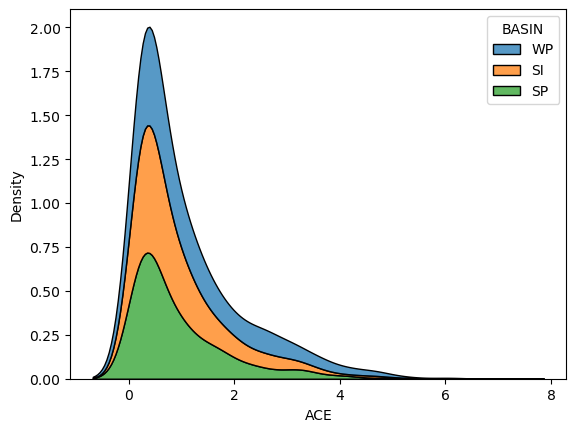

In [16]:
sns.kdeplot(cyclone_df, x='ACE', hue='BASIN', multiple='stack', common_norm=False)

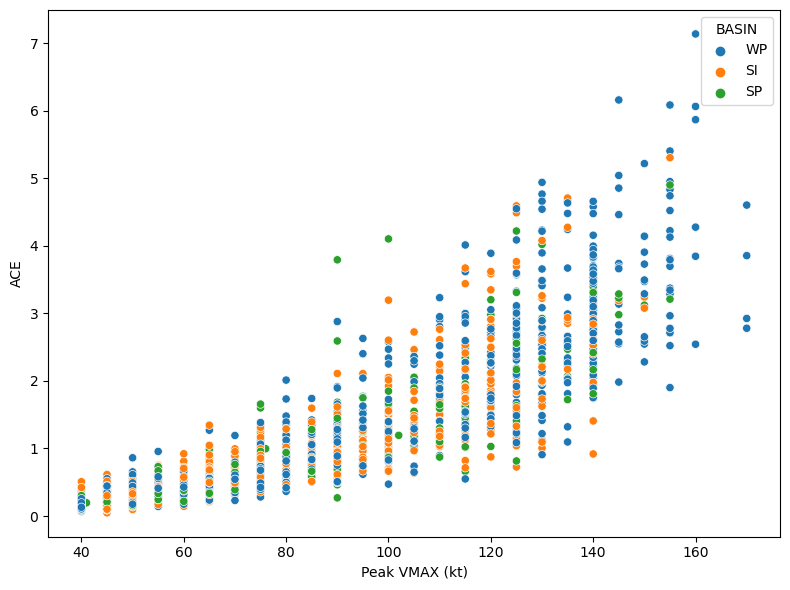

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(cyclone_df, x='Peak VMAX (kt)', y='ACE', hue='BASIN', ax=ax)
fig.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/vmax_ace_relation.png')



In [18]:
# import matplotlib.animation as animation
# from IPython.display import HTML

# ## only show origin sites for now
# min_long = severe_one_per_id['longitude'].min()
# min_lat = severe_one_per_id['latitude'].min()

# max_long = severe_one_per_id['longitude'].max()
# max_lat = severe_one_per_id['latitude'].max()
# centre_long = (max_long-min_long)/2


# HEIGHT = 5
# # fig = plt.figure(figsize=((max_long - min_long)/(max_lat-min_lat)*height, height))
# # ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= centre_long))
# # ax.set_extent([min_long - 10, max_long + 10 ,min_lat - 10,max_lat + 10], ccrs.PlateCarree())
# # ax.coastlines()
# # ax.stock_img()
# # plt.scatter(x=severe_one_per_id['longitude'], y=severe_one_per_id['latitude'], cmap='viridis',c=severe_one_per_id['Category'], transform=ccrs.PlateCarree(), s=25)
# # plt.show()

# # take rolling mean
# RUN_ANIMATION = False
# if RUN_ANIMATION:


#     fig =  plt.figure(figsize=((max_long - min_long)/(max_lat-min_lat)*height, height))
    # ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= centre_long))
    # ax.set_extent([min_long - 10, max_long + 10 ,min_lat - 10,max_lat + 10], ccrs.PlateCarree())
    # ax.coastlines()
    # ax.stock_img()
    
   
    # output = None

    # def animate(time):
    #     global output
    #     fig.suptitle("Time: " + severe_one_per_id['Time'].iloc[time], fontsize= 22)
    #     if (output is not None):
    #         output.remove()
    #     output = plt.scatter(x=severe_one_per_id['longitude'].iloc[max(time - 50, 0):time], y=severe_one_per_id['latitude'].iloc[max(time - 50, 0):time], cmap='viridis',c=severe_one_per_id['Category'].iloc[max(time - 50, 0):time], transform=ccrs.PlateCarree(), s=30)
        

    # ani = animation.FuncAnimation(fig, animate, frames= range(0, severe_one_per_id.shape[0]))


    # ani.save('./media/cyclone_animation.gif', writer='imagemagick', fps = 14) #Save animation as gif-file